In [1]:
# from dask.distributed import Client, LocalCluster
# import logging

# cluster = LocalCluster(
#     n_workers=28,
#     threads_per_worker=8,
#     silence_logs=logging.DEBUG
# )

# client = Client(cluster, heartbeat_interval=10000)

# print(client.dashboard_link)

In [31]:
import afqinsight as afqi
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import pickle
import seaborn as sns

from datetime import datetime

from sklearn.base import clone
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import median_absolute_error, r2_score
from sklearn.metrics import explained_variance_score, mean_squared_error

from neurocombat_sklearn import CombatModel

from skopt import BayesSearchCV
from skopt.plots import plot_convergence, plot_objective, plot_evaluations

print(afqi.__version__)

0.2.9.dev2565515056


In [98]:
X, y, groups, columns, group_names, subjects, classes = afqi.load_afq_data(
    "../data/raw/hbn_data",
    target_cols=["Age"],
    index_col="EID"
)

In [99]:
print(X.shape)
print(len(subjects))

(2085, 3600)
2085


In [100]:
df_y = pd.read_csv("../data/raw/hbn_data/9994_Basic_Demos_20210329.csv").drop(axis="rows", index=0)
df_y = df_y[["EID", "Age"]]
df_y = df_y.set_index("EID", drop=True)

df_subs = pd.DataFrame(index=subjects).merge(df_y, how="left", left_index=True, right_index=True)
df_subs = df_subs[~df_subs.index.duplicated(keep="first")]
print(df_subs.shape)

y = df_subs["Age"].astype(np.float64).to_numpy()
nan_mask = np.logical_not(np.isnan(y))
y = y[nan_mask]
X = X[nan_mask, :]
subjects = list(np.array(subjects)[nan_mask])

(2085, 1)


In [101]:
print(X.shape)
print(y.shape)
print(len(subjects))

(1999, 3600)
(1999,)
1999


In [102]:
len(groups)

36

In [103]:
df_sites = pd.read_csv(
    "../data/raw/hbn_data/combined_tract_profiles-20210128.csv", usecols=["subjectID", "sessionID"]
).drop_duplicates().set_index("subjectID")

df_sites = pd.DataFrame(index=subjects).merge(
    df_sites, how="left", left_index=True, right_index=True
)

site_mask = np.logical_and(
    df_sites["sessionID"] != "HBNsiteSI",
    df_sites["sessionID"] != "HBNsiteCUNY"
).to_numpy()

df_sites = df_sites[site_mask]
X = X[site_mask]
y = y[site_mask]
subjects = list(np.array(subjects)[site_mask])

df_sites["site_idx"] = df_sites["sessionID"].map({"HBNsiteRU": 0, "HBNsiteCBIC": 1})
sites = df_sites["site_idx"].to_numpy()

print(X.shape)
print(y.shape)
print(len(subjects))
print(sites.shape)
print(df_sites.isna().sum())

(1651, 3600)
(1651,)
1651
(1651,)
sessionID    0
site_idx     0
dtype: int64


<AxesSubplot:>

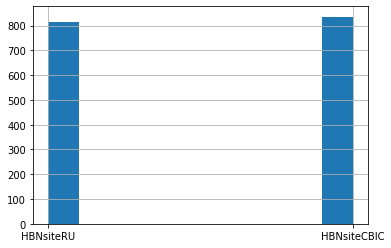

In [104]:
df_sites["sessionID"].hist()

In [105]:
def get_cv_results(n_repeats=5, n_splits=10,
                   power_transformer=False, 
                   shuffle=False,
                   ensembler=None,
                   target_transform_func=None,
                   target_transform_inverse_func=None,
                   n_estimators=10):
    if shuffle:
        rng = np.random.default_rng()
        y_fit = rng.permutation(y)
    else:
        y_fit = np.copy(y)
    
    groups_trim = [grp for grp in groups]
    X_trim = np.copy(X)
        
    cv = RepeatedKFold(
        n_splits=n_splits,
        n_repeats=n_repeats,
        random_state=1729
    )

    cv_results = {}
    pipe_skopt = afqi.make_afq_regressor_pipeline(
        imputer_kwargs={"strategy": "median"},
        use_cv_estimator=True,
        power_transformer=power_transformer,
        scaler="standard",
        groups=groups_trim,
        verbose=0,
        pipeline_verbosity=False,
        tuning_strategy="bayes",
        cv=3,
        n_bayes_points=9,
        n_jobs=28,
        l1_ratio=[0.0, 1.0],
        eps=5e-2,
        n_alphas=100,
        ensemble_meta_estimator=ensembler,
        ensemble_meta_estimator_kwargs={
            "n_estimators": n_estimators,
            "n_jobs": 1,
            "oob_score": True,
            "random_state": 1729,
        },
        target_transform_func=target_transform_func,
        target_transform_inverse_func=target_transform_inverse_func,
    )

    for cv_idx, (train_idx, test_idx) in enumerate(cv.split(X_trim, y_fit)):
        start = datetime.now()

        X_train, X_test = X_trim[train_idx], X_trim[test_idx]
        y_train, y_test = y_fit[train_idx], y_fit[test_idx]
        sites_train, sites_test = sites[train_idx].reshape(-1, 1), sites[test_idx].reshape(-1, 1)

        imputer = SimpleImputer(strategy="median")
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)

        combat = CombatModel()
        X_train = combat.fit_transform(X_train_imputed, sites_train)
        X_test = combat.transform(X_test_imputed, sites_test)
        
        pipe_skopt.fit(X_train, y_train)

        cv_results[cv_idx] = {
            "pipeline": pipe_skopt,
            "train_idx": train_idx,
            "test_idx": test_idx,
            "y_pred": pipe_skopt.predict(X_test),
            "y_true": y_test,
            "test_mae": median_absolute_error(y_test, pipe_skopt.predict(X_test)),
            "train_mae": median_absolute_error(y_train, pipe_skopt.predict(X_train)),
            "test_r2": r2_score(y_test, pipe_skopt.predict(X_test)),
            "train_r2": r2_score(y_train, pipe_skopt.predict(X_train)),
        }
        
        if ((target_transform_func is not None)
            or (target_transform_inverse_func is not None)):
            cv_results[cv_idx]["coefs"] = [
                est.coef_ for est
                in pipe_skopt.named_steps["estimate"].regressor_.estimators_
            ]
            cv_results[cv_idx]["alpha"] = [
                est.alpha_ for est
                in pipe_skopt.named_steps["estimate"].regressor_.estimators_
            ]
            cv_results[cv_idx]["l1_ratio"] = [
                est.l1_ratio_ for est
                in pipe_skopt.named_steps["estimate"].regressor_.estimators_
            ]
        else:
            cv_results[cv_idx]["coefs"] = [
                est.coef_ for est
                in pipe_skopt.named_steps["estimate"].estimators_
            ]
            cv_results[cv_idx]["alpha"] = [
                est.alpha_ for est
                in pipe_skopt.named_steps["estimate"].estimators_
            ]
            cv_results[cv_idx]["l1_ratio"] = [
                est.l1_ratio_ for est
                in pipe_skopt.named_steps["estimate"].estimators_
            ]

        if ensembler is None:
            if ((target_transform_func is not None)
                or (target_transform_inverse_func is not None)):
                cv_results[cv_idx]["optimizer"] = pipe_skopt.named_steps["estimate"].regressor_.bayes_optimizer_                
            else:
                cv_results[cv_idx]["optimizer"] = pipe_skopt.named_steps["estimate"].bayes_optimizer_

        print(f"CV index [{cv_idx:3d}], Elapsed time: ", datetime.now() - start)
        
    return cv_results, y_fit

In [106]:
results = {}

results[f"bagging_target_transform"] = get_cv_results(
    n_splits=5, n_repeats=1, power_transformer=False,
    ensembler="serial-bagging", shuffle=False, n_estimators=20,
    target_transform_func=np.log, target_transform_inverse_func=np.exp,
)

CV index [  0], Elapsed time:  0:35:36.593104
CV index [  1], Elapsed time:  0:31:22.596838
CV index [  2], Elapsed time:  0:36:53.565037
CV index [  3], Elapsed time:  0:40:34.561460
CV index [  4], Elapsed time:  0:40:37.921565


In [109]:
with open("hbn_regression_paper.pkl", "wb") as fp:
    pickle.dump(results, fp)

In [110]:
for metric in ["test_mae", "test_r2", "train_mae", "train_r2"]:
    for key, res in results.items():
        mean_metric = [cvr[metric] for cvr in res[0].values()]
        print(metric, key, np.mean(mean_metric))
    
    print()

test_mae bagging_target_transform 1.437749942049527

test_r2 bagging_target_transform 0.5701046757404507

train_mae bagging_target_transform 1.3079183135589436

train_r2 bagging_target_transform 0.656782761802513

